In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
hallmark = pd.read_excel('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/FW__MCF10A_wild_type_and_PIK3CA_H1047R_knock-in_cell_lines/Supplementary Table S4.xlsx', 
    sheet_name='MCF10A_hallmark_PI3K_Activation')

In [3]:
from utils import Data, get_ppi_edge_list

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [4]:
hallmark_mask = np.load('hallmark_mask.npy')

In [5]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd
import warnings 
from pathlib import Path
from tqdm import tqdm
warnings.filterwarnings("ignore")
from sklearn import metrics

import yaml

with open('args.yaml', 'r') as f:
    args_dict = yaml.safe_load(f)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()
args = argparse.Namespace(**args_dict)
args.tf_gene = np.load('tf_gene.npy')

In [7]:
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)

train_set, test_set = split_dataset(dataset, ratio=0.66)

daata = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb") )
cancers = daata['idx2can']


models = []
for m in tqdm(list(Path('/ix/hosmanbeyoglu/kor11/output').iterdir())):
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    model.load_model(m, device=device)
    model.eval()
    models.append(model)


random_models = []
for m in tqdm(list(Path('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output').glob('random_model*.pth'))):
    model = CITRUS(args) 
    model.build(device=device)
    model.to(device);
    model.load_model(m, device=device)
    model.eval()
    random_models.append(model)

100%|██████████| 3/3 [00:00<00:00, 30.43it/s]


In [8]:
from utils import Data 

data_csv = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

data = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb"))


df = pd.DataFrame(np.column_stack([data['tmr'], data['can']]), columns=['tmr', 'cancer'])
df['cancer'] = df['cancer'].astype(int).replace(data['idx2can'])
xdf = pd.read_parquet('xdf.parquet') 


import gzip

def split_mutants(cancer, gene):    
    if gene is None:
        dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
        idx = xdf[xdf.id.isin(dframe.index)].idx.values
        return idx
        


    _sm = f'SM_{gene}'
    _scna = f'SCNA_{gene}'
    
    if not cancer:
        dframe = data_csv.sga_sga.loc[df.tmr]
    else:
        dframe = data_csv.sga_sga.loc[df[df.cancer==cancer].tmr]
    
    wt = dframe[(dframe[_sm] == 0) & (dframe[_scna] == 0)]
    sm = dframe[(dframe[_sm] == 1) & (dframe[_scna] == 0)]
    idx = xdf[xdf.id.isin(wt.index)].idx.values
    idy = xdf[xdf.id.isin(sm.index)].idx.values

    return idx, idy
    


f = gzip.GzipFile('sga.npy.gz', 'r')
sga = np.load(f)
f.close()

g = gzip.GzipFile('can.npy.gz', 'r')
can = np.load(g)
g.close()

In [53]:

cancerss = df['cancer'].unique()
cancer_results = []

for cancer in tqdm(cancerss):

    random = None
    nonrandom = None
    
    for model in random_models:
        model.eval()

        X = torch.from_numpy(sga)[split_mutants(cancer, None)]
        C = torch.from_numpy(can)[split_mutants(cancer, None)]
        r = model(X, C, pathways=True).data.numpy()

        if random is None:
            random = r
        else:
            random += r



    for model in models:
        model.eval()

        X = torch.from_numpy(sga)[split_mutants(cancer, None)]
        C = torch.from_numpy(can)[split_mutants(cancer, None)]
        s = model(X, C, pathways=True).data.numpy()

        if nonrandom is None:
            nonrandom = s
        else:
            nonrandom += s


    random = random / len(random_models)
    nonrandom = nonrandom / len(models)
    cancer_results.append([Counter(fdrcorrection(ttest_1samp(random[:, i], random[:, i][:]).pvalue)[0])[True]/len(random) for i in range(50)])



100%|██████████| 17/17 [01:52<00:00,  6.63s/it]


In [ ]:
(1-pd.DataFrame(cancer_results, index=cancerss, columns=hallmark.Description.values).T).to_csv('pathway_heatmap.csv')

<AxesSubplot:>

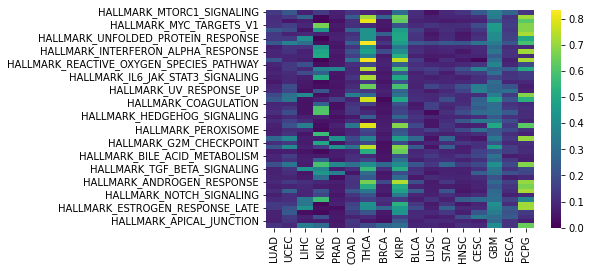

In [59]:
sns.heatmap(1-pd.DataFrame(cancer_results, index=cancerss, columns=hallmark.Description.values).T, cmap='viridis')

In [29]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
import seaborn as sns

[0.8566433566433567,
 0.986013986013986,
 0.993006993006993,
 0.33916083916083917,
 0.5559440559440559,
 0.9230769230769231,
 0.9965034965034965,
 0.9685314685314685,
 0.5664335664335665,
 0.513986013986014,
 0.5,
 1.0,
 0.972027972027972,
 0.6293706293706294,
 0.7482517482517482,
 0.48951048951048953,
 0.9825174825174825,
 0.972027972027972,
 0.7762237762237763,
 0.965034965034965,
 0.9230769230769231,
 0.7377622377622378,
 0.3986013986013986,
 0.3951048951048951,
 0.9195804195804196,
 0.9545454545454546,
 0.972027972027972,
 0.9790209790209791,
 0.43356643356643354,
 0.9335664335664335,
 0.5034965034965035,
 0.8566433566433567,
 0.9790209790209791,
 0.9440559440559441,
 0.7482517482517482,
 0.4090909090909091,
 0.6223776223776224,
 0.5559440559440559,
 0.7062937062937062,
 0.9090909090909091,
 0.9335664335664335,
 0.7867132867132867,
 0.8286713286713286,
 0.43006993006993005,
 0.986013986013986,
 0.965034965034965,
 0.9790209790209791,
 0.8041958041958042,
 0.9335664335664335,
 0.706

In [27]:
[Counter(fdrcorrection(ttest_1samp(nonrandom[:, i], nonrandom[:, i][:]).pvalue)[0])[True]/len(random) for i in range(50)]

[0.9265734265734266,
 0.8391608391608392,
 0.8671328671328671,
 0.9020979020979021,
 0.8741258741258742,
 0.9020979020979021,
 0.8706293706293706,
 0.916083916083916,
 0.8706293706293706,
 0.8951048951048951,
 0.8426573426573427,
 0.8566433566433567,
 0.8986013986013986,
 0.9230769230769231,
 0.8846153846153846,
 0.8776223776223776,
 0.8671328671328671,
 0.8741258741258742,
 0.8986013986013986,
 0.9125874125874126,
 0.8881118881118881,
 0.8916083916083916,
 0.8706293706293706,
 0.8671328671328671,
 0.9125874125874126,
 0.8916083916083916,
 0.9195804195804196,
 0.8846153846153846,
 0.8811188811188811,
 0.8566433566433567,
 0.9125874125874126,
 0.9090909090909091,
 0.916083916083916,
 0.9055944055944056,
 0.8566433566433567,
 0.8846153846153846,
 0.8881118881118881,
 0.9020979020979021,
 0.8951048951048951,
 0.8706293706293706,
 0.8846153846153846,
 0.9020979020979021,
 0.8986013986013986,
 0.8706293706293706,
 0.8846153846153846,
 0.8811188811188811,
 0.9090909090909091,
 0.895104895104

In [76]:
for i in range(len(random)):
    print(hallmark.Description.values[i], Counter(fdrcorrection([ttest_1samp(nonrandom[:, i], random[:, 1][x]).pvalue for x in range(len(nonrandom[:, 1]))])[0]))

HALLMARK_MTORC1_SIGNALING Counter({True: 286})
HALLMARK_MYC_TARGETS_V2 Counter({True: 286})
HALLMARK_INTERFERON_GAMMA_RESPONSE Counter({True: 286})
HALLMARK_MYC_TARGETS_V1 Counter({True: 286})
HALLMARK_GLYCOLYSIS Counter({True: 286})
HALLMARK_OXIDATIVE_PHOSPHORYLATION Counter({True: 286})
HALLMARK_UNFOLDED_PROTEIN_RESPONSE Counter({True: 283, False: 3})
HALLMARK_HYPOXIA Counter({True: 273, False: 13})
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION Counter({True: 286})
HALLMARK_INTERFERON_ALPHA_RESPONSE Counter({True: 286})
HALLMARK_TNFA_SIGNALING_VIA_NFKB Counter({True: 286})
HALLMARK_XENOBIOTIC_METABOLISM Counter({True: 286})
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY Counter({True: 286})
HALLMARK_DNA_REPAIR Counter({True: 285, False: 1})
HALLMARK_INFLAMMATORY_RESPONSE Counter({True: 286})
HALLMARK_IL6_JAK_STAT3_SIGNALING Counter({True: 286})
HALLMARK_FATTY_ACID_METABOLISM Counter({True: 286})
HALLMARK_COMPLEMENT Counter({True: 286})
HALLMARK_UV_RESPONSE_UP Counter({True: 286})
HALLMARK_ADI

IndexError: index 50 is out of bounds for axis 0 with size 50

'HALLMARK_KRAS_SIGNALING_DN'

<AxesSubplot:ylabel='Description'>

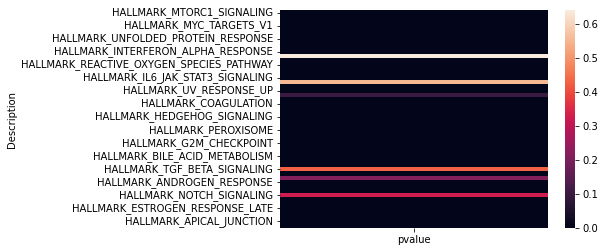

In [32]:
sns.heatmap(pd.DataFrame(ttest_ind(random, nonrandom).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True).loc[hallmark.Description])

In [24]:
[m.pval_corr for m in models]

[0.3228966580749612,
 0.3056089131453084,
 0.3207356899587547,
 0.3023434502141517,
 0.3099308493777216,
 0.3081540533710628,
 0.3011909338855082,
 0.3060411067685497,
 0.3019592781046038,
 0.3128601617130239]

In [28]:
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [13]:
# results = pd.DataFrame(np.array([m.performance for m in models]).mean(0), columns = ['corr', 'mse'])
# results['corr_std'] = np.array([m.performance for m in models]).std(0)[:, 0]
# results['mse_std'] = np.array([m.performance for m in models]).std(0)[:, 1]
# results = results[['corr', 'corr_std', 'mse', 'mse_std']]
# results.index = models[0].cancers

In [14]:
# results.to_csv('perf_shuffled_across.csv')

((4415,), (150,))

In [28]:
clinical_from_cbioportal = pd.read_table('https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/hnsc_tcga_pan_can_atlas_2018/data_clinical_patient.txt')
clinical_from_cbioportal = clinical_from_cbioportal.drop([0, 1, 2, 3])
clinical_from_cbioportal = clinical_from_cbioportal.set_index('#Patient Identifier')
traits = clinical_from_cbioportal[['Subtype']].copy()
traits.index.name = None
traits.columns = ['hpv']
traits = traits.dropna()
traits.hpv = traits.hpv.replace({'HNSC_HPV-': 0, 'HNSC_HPV+': 1})

In [69]:
idx = xdf[xdf.id.isin(traits[traits.hpv==1].index)].idx.values
idy = xdf[xdf.id.isin(traits[traits.hpv==0].index)].idx.values

In [80]:
idx.shape, idy.shape

((60,), (314,))

In [31]:
from tqdm import tqdm

In [53]:
R = None
S = None

for model in tqdm(models):
    model.eval()

    X = torch.from_numpy(sga)[idx]
    C = torch.from_numpy(can[idx])
    r = model(X, C, pathways=True).data.numpy()

    if R is None:
        R = r
    else:
        R += r

    X = torch.from_numpy(sga)[idy]
    C = torch.from_numpy(can[idy])
    s = model(X, C, pathways=True).data.numpy()

    if S is None:
        S = s
    else:
        S += s    

100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


In [65]:
dx.columns

Index(['pvalue'], dtype='object')

In [72]:
dx = pd.DataFrame(ttest_ind(R, S).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True)

dx.to_csv('./NFE2L2.csv')

In [33]:
R = R / len(models)
S = S / len(models)

p_predicted = pd.DataFrame(ttest_ind(R, S).pvalue, 
        index=hallmark.Description, 
        columns=['pvalue']).sort_values(by='pvalue', ascending=True).loc[hallmark.Description].pvalue.values

p_exp = hallmark['pvalue'].values
spearmanr(p_predicted, p_exp)

SpearmanrResult(correlation=-0.07645024980002056, pvalue=0.5977177899674204)

In [77]:
from statsmodels.stats.multitest import fdrcorrection

In [81]:
help(fdrcorrection)

Help on function fdrcorrection in module statsmodels.stats.multitest:

fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False)
    pvalue correction for false discovery rate.
    
    This covers Benjamini/Hochberg for independent or positively correlated and
    Benjamini/Yekutieli for general or negatively correlated tests.
    
    Parameters
    ----------
    pvals : array_like, 1d
        Set of p-values of the individual tests.
    alpha : float, optional
        Family-wise error rate. Defaults to ``0.05``.
    method : {'i', 'indep', 'p', 'poscorr', 'n', 'negcorr'}, optional
        Which method to use for FDR correction.
        ``{'i', 'indep', 'p', 'poscorr'}`` all refer to ``fdr_bh``
        (Benjamini/Hochberg for independent or positively
        correlated tests). ``{'n', 'negcorr'}`` both refer to ``fdr_by``
        (Benjamini/Yekutieli for general or negatively correlated tests).
        Defaults to ``'indep'``.
    is_sorted : bool, optional
        If Fals

In [80]:
# fdrcorrection(p_predicted)

In [74]:
# pd.DataFrame(ttest_ind(R, S).pvalue, 
#         index=hallmark.Description, 
#         columns=['pvalue']).sort_values(by='pvalue', ascending=True).to_csv('HPV_analysis.csv')

In [75]:
# np.save('p_predicted2.npy', p_predicted)
# np.save('p_exp2.npy', p_exp)

array([-0.03885234, -0.01304751, -0.0700935 , -0.05409943, -0.04236699,
       -0.06662035, -0.07512558, -0.04664319, -0.06729268, -0.04858711])

array([0.84551702, 0.87585314, 0.86683599, 0.87819618, 0.88397833,
       0.83529452, 0.90377233, 0.88774731, 0.86372933, 0.84456712,
       0.86610128, 0.86751381, 0.79801956, 0.92775074, 0.86453251,
       0.86601414, 0.87669903])